In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import random
import glob
import yaml

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1, style='white')

In [23]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [24]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [25]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"
mapping01["param__func__de.upb.lb-nginx.0.1__mem_max"] = "Memory"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"
mapping03["param__func__de.upb.px-squid.0.1__mem_max"] = "Memory"

web1 = select_and_rename(web1, mapping01)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [26]:
# select sub-datasets with small and large flows
# and with specific memory
mem = 128

web1_small = web1.loc[(web1["size"] == "small") & (web1["Memory"] == mem)]
web1_small = web1_small[["Max. throughput [kB/s]", "CPU"]]
web3_small = web3.loc[(web3["size"] == "small")  & (web3["Memory"] == mem)]
web3_small = web3_small[["Max. throughput [kB/s]", "CPU"]]

# add 20 "measurements" at 0 CPU and throuhgput
num_measures = 20
measures = [0 for _ in range(num_measures)]
web1_small = web1_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_small = web3_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)

In [27]:
def prepare_data(data):
    """Split return data"""
    X = data[['Max. throughput [kB/s]']]
    y = data['CPU']
    X = X.fillna(X.median())

    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    
    return X, y

In [28]:
# prepare data
X_nginx, y_nginx = prepare_data(web1_small)
X_squid, y_squid = prepare_data(web3_small)

X_nginx.head()

,Max. throughput [kB/s]
0,516.81
1,493.60
2,519.22
3,514.01
4,518.83


In [29]:
def training_times(model, X, y, k=5):
    """Train the given model k times on the data and return training times"""
    times = []
    for _ in range(k):
        start = time.time()
        model.fit(X, y)
        end = time.time()
        times.append(end - start)
    return times

In [30]:
def barplot(times, labels):
    assert len(times) == len(labels)
    
    times_mean = [t.mean() for t in times]
    print(times_mean)
    times_std = [t.std() for t in times]
    
    x = np.arange(len(labels))
    fig, ax = plt.subplots()
    plt.bar(x, times_mean, yerr=times_std, capsize=5)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Time [s]')

[0.002081775665283203, 0.0005206982294718425, 0.004686307907104492, 0.007291261355082194, 0.018224930763244628, 0.06241048971811931, 0.0]


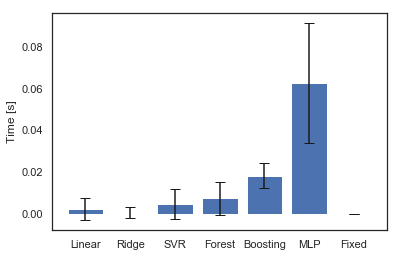

In [31]:
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
          FixedModel(fixed_value=0.8)]
train_times = np.array([training_times(models[i], X_nginx, y_nginx, k=30) for i in range(len(models))])

barplot(train_times, labels)

In [32]:
def prediction_times(model, X, k=100):
    """Predict y for given X with trained model. Repeat num_repetitions times and measure times"""   
    times = []
    for _ in range(k):
        start = time.time()
        y = model.predict(X)
        stop = time.time()
        times.append(stop - start)
    return times

[0.000624842643737793, 0.00046864032745361326, 0.0006254100799560547, 0.0017177963256835938, 0.000624849796295166, 0.0004687619209289551, 0.0]


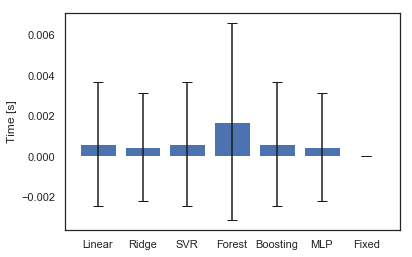

In [33]:
X_rand = pd.DataFrame(data={'Rand throughput': [random.randrange(0, 3000) for _ in range(1)]})
pred_times = np.array([prediction_times(models[i], X_rand, k=100) for i in range(len(models))])

barplot(pred_times, labels)

In [38]:
def sum_cpu(node_res):
    """Return sum of CPU resources allocated to all nodes"""
    cpu = sum([v['cpu'] for v in node_res])
    return cpu

def read_placement(placement, df_data, flow_dr=250):
    """Read placement dict and write it to df_data. Then return."""
    df_data['num_flows'].append(placement['input']['num_flows'])
    df_data['num_sources'].append(placement['input']['num_sources'])
    df_data['source_dr'].append(placement['input']['num_flows'] * flow_dr)
    df_data['num_instances'].append(placement['metrics']['num_instances'])
    df_data['max_e2e_delay'].append(placement['metrics']['max_endToEnd_delay'])
    df_data['total_delay'].append(placement['metrics']['total_delay'])
    df_data['runtime'].append(placement['metrics']['runtime'])
    df_data['total_cpu'].append(sum_cpu(placement['placement']['alloc_node_res']))
    return df_data

def read_results(results):
    """Read result files matching the pattern and return df containing their metrics"""
    data = {'num_sources' : [], 'num_flows': [], 'source_dr': [], 'num_instances': [], 
            'max_e2e_delay': [], 'total_delay': [], 'runtime': [], 'total_cpu': []}

    # iterate through result files
    for res in glob.glob(results):
        # open and save metrics of interest
        with open(res, 'r') as f:
            placement = yaml.load(f)
            data = read_placement(placement, data)

    return pd.DataFrame(data).sort_values(by=['num_flows'])

In [39]:
# read results
dataset = 'web_data'
sources = 'runtime'
results = f'placement_data/{dataset}/{sources}/'

df_true = read_results(results + 'true/*.yaml')
df_fixed = read_results(results + 'fixed/*.yaml')
df_linear = read_results(results + 'linear/*.yaml')
df_boost = read_results(results + 'boosting/*.yaml')
df_svr = read_results(results + 'svr/*.yaml')
df_ml = read_results(results + 'ml/*.yaml')

df_linear

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\ipykernel_launcher.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


,num_sources,num_flows,source_dr,num_instances,max_e2e_delay,total_delay,runtime,total_cpu
0,3,24,6000,11,66,88,1.076092,3.907585
27,3,24,6000,11,64,84,0.726341,3.907585
26,3,24,6000,11,66,88,1.032155,3.907585
25,3,24,6000,11,66,88,0.906801,3.907585
24,3,24,6000,11,64,84,0.721183,3.907585
23,3,24,6000,11,64,84,0.733504,3.907585
22,3,24,6000,11,64,88,0.904226,3.907585
21,3,24,6000,11,64,88,0.905682,3.907585
20,3,24,6000,11,65,88,1.280145,3.907585
19,3,24,6000,11,64,88,1.205016,3.907585


[1.319931435585022, 1.0002400318781535, 1.2721559921900432]


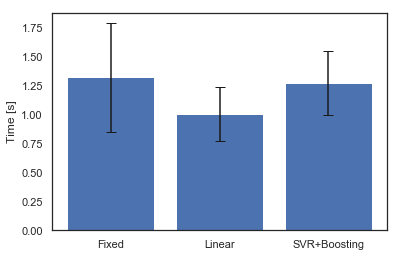

In [40]:
placement_times = [df_fixed['runtime'], df_linear['runtime'], df_ml['runtime']]
labels = ['Fixed', 'Linear', 'SVR+Boosting']

barplot(placement_times, labels)